In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sales_processing import fill_in_dates, add_date_features, kung_i_baren, normalize_sales, denormalize_sales
from holiday_processing import add_holidays

In [2]:
sales = pd.read_csv('data/caspecoTrainingData.csv')


sales, norms = normalize_sales(sales)
sales = fill_in_dates(sales, pd.date_range('2020-01-01', '2023-01-04'))
sales = add_date_features(sales)
sales = kung_i_baren(sales)
#sales = sales.drop(columns=['Weekend', 'Workday'], axis=1)

sales = add_holidays(sales, pd.read_csv('data/swedish_holidays.csv'))


sales.head()

,Date,Company,Sales,Day,Week,Month,Year,Weekday,Weekend,Workday,Payweek,Payday,Holiday,Holieve
2,2020-01-01,0,0.000000,1,1,1,0,2,0,1,0,0,1,0
1,2020-01-01,1,0.000000,1,1,1,0,2,0,1,0,0,1,0
0,2020-01-01,2,0.004759,1,1,1,0,2,0,1,0,0,1,0
5,2020-01-02,0,0.016313,2,1,1,0,3,0,1,0,0,0,0
4,2020-01-02,1,0.032005,2,1,1,0,3,0,1,0,0,0,0


In [3]:
def lag_data(df, lag):
    # lag every column in df by lag
    df = df.copy()
    for col in df.columns:
      for i in range(1, lag+1):
        df[f'{col}_lag{i}'] = df[col].shift(i)
    return df

def lag_sales(df, lag):
    # lag sales by lag
    df = df.copy()
    for i in range(1, lag+1):
        df[f'Sales_lag{i}'] = df['Sales'].shift(i)
    return df

In [4]:
LAG = 0

company_sales = [sales[sales['Company'] == company].drop(['Company'], axis=1) for company in sales['Company'].unique()]
company_data = [company_sales[i].drop(['Sales','Date'],axis = 1).dropna() for i in range(len(company_sales))]
company_target = [company_sales[i]['Sales'] for i in range(len(company_sales))]
company_data[0].head()

,Day,Week,Month,Year,Weekday,Weekend,Workday,Payweek,Payday,Holiday,Holieve
2,1,1,1,0,2,0,1,0,0,1,0
5,2,1,1,0,3,0,1,0,0,0,0
8,3,1,1,0,4,1,0,0,0,0,0
11,4,1,1,0,5,1,0,0,0,0,0
14,5,1,1,0,6,0,0,0,0,0,0


/tmp/ipykernel_74854/1615895506.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y = company_target[company][LAG:]
/tmp/ipykernel_74854/1615895506.py:15: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train = y[:-start_test]
/tmp/ipykernel_74854/1615895506.py:17: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the ol

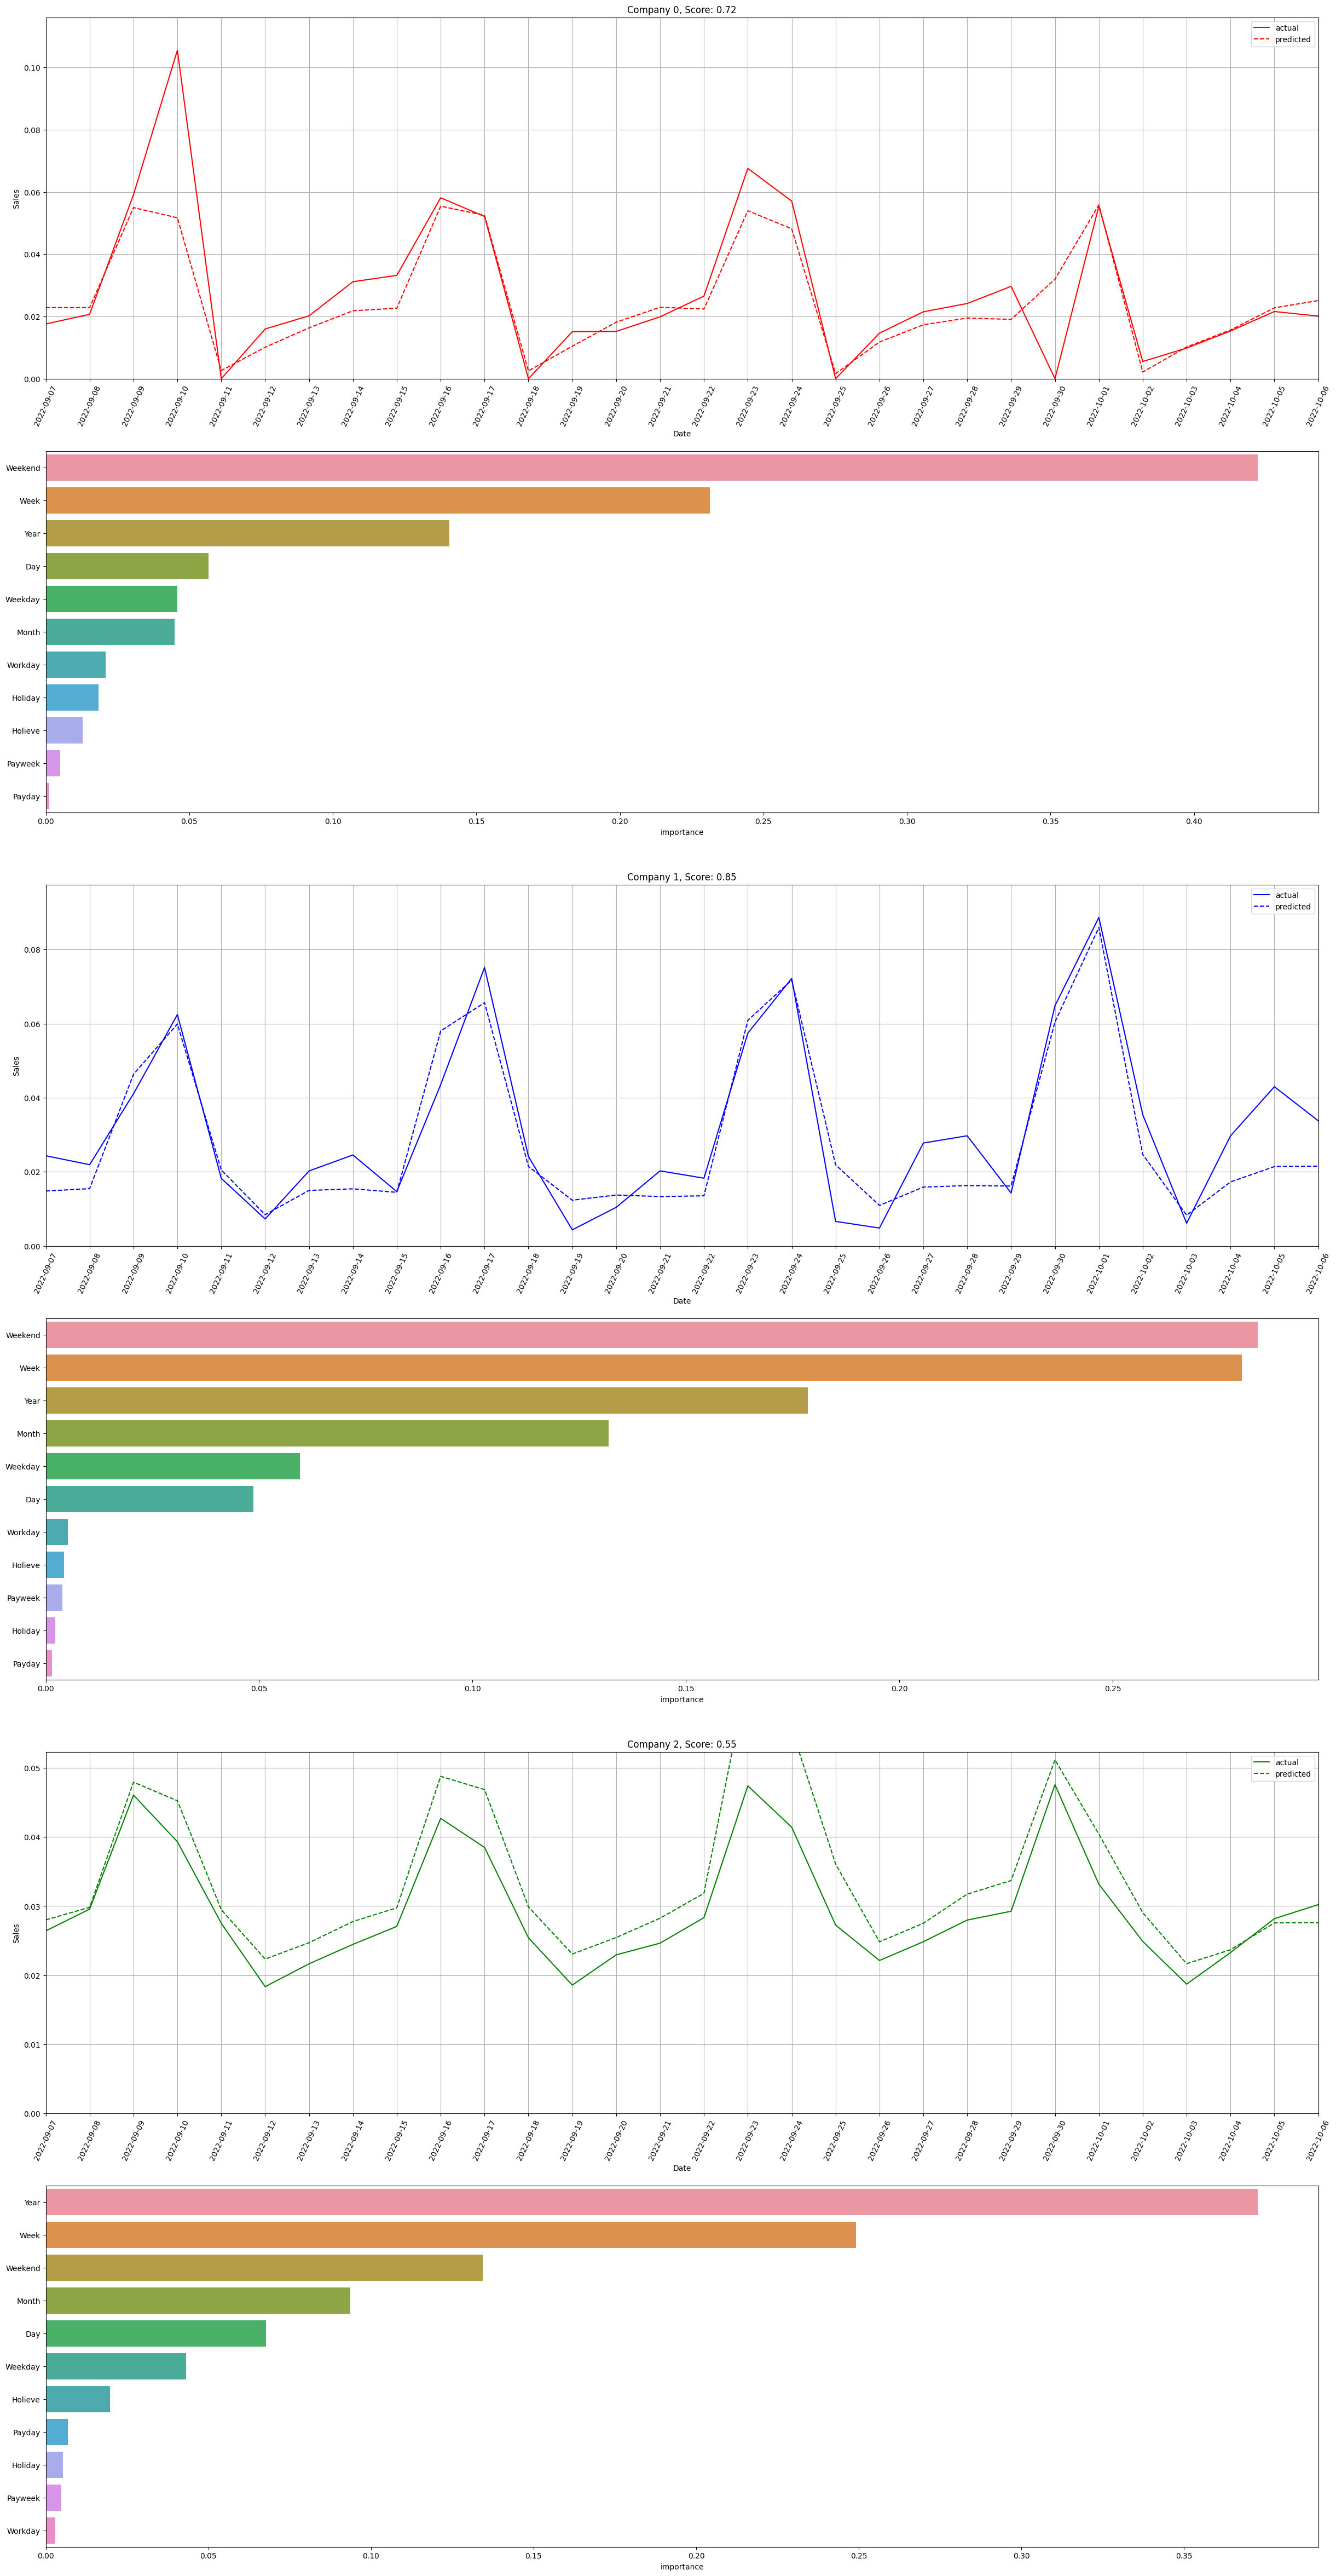

In [5]:
from sklearn.ensemble import RandomForestRegressor

start_test = 120
end_test = 90

fig, axs = plt.subplots(6, 1, figsize=(30, 60))
colors = ['red', 'blue', 'green']

unique_dates = sales['Date'].unique()
for company in [0,1,2]:
  X = company_data[company]
  y = company_target[company][LAG:]

  X_train = X[:-start_test]
  y_train = y[:-start_test]
  X_test = X[-start_test:-end_test]
  y_test = y[-start_test:-end_test]

  model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  test_dates = unique_dates[-start_test:-end_test]

  axs[company*2].plot(test_dates, y_test, label='actual', color=colors[company])
  axs[company*2].plot(test_dates, y_pred, label='predicted', color=colors[company], linestyle='--')
  axs[company*2].set_title(f'Company {company}, Score: {model.score(X_test, y_test):.2f}')
  axs[company*2].legend()
  axs[company*2].set_xlabel('Date')
  axs[company*2].set_ylabel('Sales')
  axs[company*2].tick_params(axis='x', labelrotation=65)
  axs[company*2].set_xticks(test_dates)
  axs[company*2].grid(True)
  axs[company*2].set_ylim(0, y_test.max() * 1.1)
  axs[company*2].set_xlim(test_dates[0], test_dates[-1])

  feature_importances = pd.DataFrame(model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
  # bar plot of feature importances using sns
  sns.barplot(x=feature_importances['importance'], y=feature_importances.index, ax=axs[company*2+1])


  